# Continuous Control

---

This notebook contains the solution implemented for the "Continuous Control" project based on a Unity's ML-Agents environment. This is the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).



## 1. Solution description

The project consist of the resolution of the environment with a single agent where the Deep Deterministic Policy Gradients (DDPG) algorithm was used to solve the scenario with one agent.

<p align="middle"><img src="images\actor-critic.png" width="600"></p>

The algorithm shown in the Lesson 6 (Deep RL for Finance) has been used as reference, but the networks and the hyperparameters have been defined from scratch and have been tuned from testing.

<p align="middle"><img src="images\networks.png" width="600"></p>

Once the agent reach the specified goal (get an average score of +30 over 100 consecutive episodes), both networks are saved (actor and critic) in the checkpoints directory and and a graph with the scores and the running means (for a window of 100 episodes) is plotted.

The project solution is comprised of this same jupyter notebook (Continuous_Control.ipynb) and the following files:

* ddpg_agent.py: Contains the agent implementation that applies the DDPG algorithm for learning.
* ddpg_model.py: Contains the definition of the networks for the actor and the critic parts used in the DDPG algorithm.

* utils: Contains utility functions.

## 2. Training phase

### 1. Importing the required packages

We begin by importing some necessary packages. ddpg_agent and utils are modules developed as part of the solution.

In [11]:
import numpy as np
import torch
from collections import deque
from ddpg_agent import DDPGAgent
from utils import load_checkpoint, save_checkpoint, plot_scores
%matplotlib inline

### 2. Setting the model and training parameters 

Next, a series of constants are defined that will allow the model to be parameterized centrally throughout the project. This avoids having to go through different files to configure the parameters and avoids errors in the training phase.

In [2]:
N_EPISODES = 500                                # Max number of episodes for the training
MAX_T = 1000                                    # Max number of steps per episode

SCORES_WINDOW = 100                             # Size for the window of the average score

STATE_SIZE = 33                                 # Size for the observation state
ACTION_SIZE = 4                                 # Size for the action
RANDOM_SEED = 777                               # Random seed
UNITY_ENV_1_PATH = 'Reacher_Windows_x86_64_1_agent\Reacher.exe'         #Path for the Unity environment

# Agent parameters
BUFFER_SIZE = 100000                            # Size for the replay memory
BATCH_SIZE = 128                                # Size for the minibatch
GAMMA = 0.99                                    # Discount factor
TAU = 1e-3                                      # Parameter for soft update of Q_target 
LR_ACTOR = 1.5e-4                               # Learning rate of the actor 
LR_CRITIC = 1.5e-4                              # Learning rate of the critic
WEIGHT_DECAY = 1e-4                             # L2 weight decay

# Network parameters
HIDDEN_LAYERS = (600, 400)                      # Tuple with the sizes for the hidden layers (generated dynamically from these values)

CHECKPOINTS_PATH = "checkpoints"                # Directory for the checkpoints of the network weights
ACTOR_CHECKPOINT = "actor_checkpoint"           # Prefix for the name of the actor checkpoint
CRITIC_CHECKPOINT = "critic_checkpoint"         # Prefix for the name of the critic checkpoint

### 3. Configuring where the model will run
GPU processing is configured whenever possible, a message indicates whether the model will be trained/executed on the CPU or on the GPU using CUDA.

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 4. Starting up the environment

A DDPG agent is instantiated and the environment is started.  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

* Linux: [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/one_agent/Reacher_Linux.zip)
* Mac OSX: [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/one_agent/Reacher.app.zip)
* Windows (32-bit): [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/one_agent/Reacher_Windows_x86.zip)
* Windows (64-bit): [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/one_agent/Reacher_Windows_x86_64.zip)

(_For Windows users_) Check out [this link](https://support.microsoft.com/en-us/help/827218/how-to-determine-whether-a-computer-is-running-a-32-bit-version-or-64) if you need help with determining if your computer is running a 32-bit version or 64-bit version of the Windows operating system.

(_For AWS_) If you'd like to train the agent on AWS (and have not [enabled a virtual screen](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Training-on-Amazon-Web-Service.md)), then please use [this link](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/one_agent/Reacher_Linux_NoVis.zip) (version 1) or [this link](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/Reacher_Linux_NoVis.zip) (version 2) to obtain the "headless" version of the environment.  You will **not** be able to watch the agent without enabling a virtual screen, but you will be able to train the agent.  (_To watch the agent, you should follow the instructions to [enable a virtual screen](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Training-on-Amazon-Web-Service.md), and then download the environment for the **Linux** operating system above._)

In [4]:
agent = DDPGAgent(state_size=STATE_SIZE, action_size=ACTION_SIZE, hidden_layers=HIDDEN_LAYERS, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, tau=TAU, lr_actor=LR_ACTOR, lr_critic=LR_CRITIC, weight_decay=WEIGHT_DECAY, random_seed=RANDOM_SEED)            
     
from unityagents import UnityEnvironment
env = UnityEnvironment(file_name = UNITY_ENV_1_PATH)
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

d:\Git-projects\Udacity-Deep-Reinforcement-Learning-Nanodegree\p2_continuous-control\ddpg_model.py:41: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight.data)


critic_layers:ModuleList(
  (0): Linear(in_features=37, out_features=600, bias=True)
  (1): Linear(in_features=600, out_features=400, bias=True)
)
critic_layers:ModuleList(
  (0): Linear(in_features=37, out_features=600, bias=True)
  (1): Linear(in_features=600, out_features=400, bias=True)
)


d:\Git-projects\Udacity-Deep-Reinforcement-Learning-Nanodegree\p2_continuous-control\ddpg_model.py:89: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight.data)
INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 5. Examining the State and Action Spaces

In this environment, a double-jointed arm can move to target locations, the observations space has a dimension of 33.  At each time step the agent returns an action composed of 4 values that take values in the continuous interval from 1 to -1.

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print(f"There are {states.shape[0]} agents. Each observes a state with length: {state_size}")
print(f"The state for the first agent looks like:{states[0]}")

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like:[ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 7. Training the model

In the next code cell we are going to train the agent in the running environment.

Here the agent will run several episodes (with the maximum specified) each one with a maximum of 1000 timesteps.

Once the goal is achieved the training stops and the weights for the actor and the critic networks will be saved.

After this, a graph with the increasing score along the episodes will be plotted with the moving averages for 100 episodes.


Episode 10	Average Score: 0.97
Episode 20	Average Score: 1.80
Episode 30	Average Score: 3.35
Episode 40	Average Score: 5.41
Episode 50	Average Score: 8.31
Episode 60	Average Score: 11.38
Episode 70	Average Score: 13.41
Episode 80	Average Score: 15.40
Episode 90	Average Score: 17.31
Episode 100	Average Score: 18.80
Episode 110	Average Score: 22.24
Episode 120	Average Score: 25.69
Episode 130	Average Score: 28.75
 Environment Solved in Episode 135	Average Score: 30.05


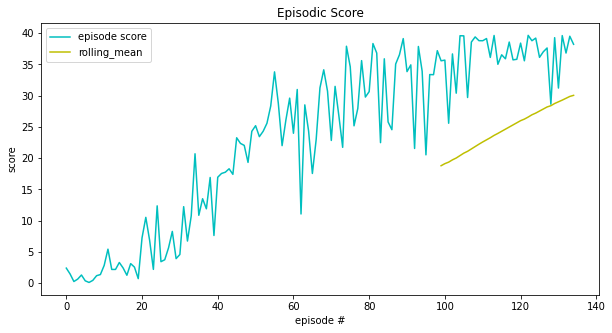

In [7]:
def ddpg(n_episodes, max_t):
    scores_deque = deque(maxlen=SCORES_WINDOW) 
    max_score = -np.Inf 
    avg_score = []
    update_step = 5
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]  
        states = env_info.vector_observations                  # get the current state (for each agent) 
        scores = np.zeros(num_agents)
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            agent.step(states, actions, rewards, next_states, dones)
            scores += rewards                                  # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        score = np.mean(scores)
        scores_deque.append(score)
        avg_score.append(np.mean(score))
        if i_episode % 10 == 0:
            print(f"\rEpisode {i_episode}\tAverage Score: {np.mean(scores_deque):.2f}")
        if np.mean(scores_deque) >= 30:
            print(f"\r Environment Solved in Episode {i_episode}\tAverage Score: {np.mean(scores_deque):.2f}")
            save_checkpoint(agent.actor_local, path=CHECKPOINTS_PATH, name_prefix=ACTOR_CHECKPOINT)
            save_checkpoint(agent.critic_local, path=CHECKPOINTS_PATH, name_prefix=CRITIC_CHECKPOINT)
            break
    return avg_score

scores = ddpg(n_episodes=N_EPISODES, max_t=MAX_T)

plot_scores(scores)

## 3. Validation phase

The trained model will then be loaded and its performance in the Unity environment will be shown:

In [9]:
agent = DDPGAgent(state_size=STATE_SIZE, action_size=ACTION_SIZE, hidden_layers=HIDDEN_LAYERS, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, tau=TAU, lr_actor=LR_ACTOR, lr_critic=LR_CRITIC, weight_decay=WEIGHT_DECAY, random_seed=RANDOM_SEED)

load_checkpoint(agent.actor_local, CHECKPOINTS_PATH, "actor_checkpoint1653322072.pth")
load_checkpoint(agent.critic_local, CHECKPOINTS_PATH, "critic_checkpoint1653322072.pth")

agent.actor_local.to(device)
agent.critic_local.to(device)

env_info = env.reset(train_mode=False)[brain_name]  
states = env_info.vector_observations
for t in range(500):
    actions = agent.act(states)                        # take the actions from the agent
    env_info = env.step(actions)[brain_name]           # send actions to tne environment
    next_states = env_info.vector_observations         # get next state
    rewards = env_info.rewards                         # get reward
    dones = env_info.local_done   
    states = next_states                               # next state is the current state now
    if np.any(dones):                                  # exit if episode finished
        break 

critic_layers:ModuleList(
  (0): Linear(in_features=37, out_features=600, bias=True)
  (1): Linear(in_features=600, out_features=400, bias=True)
)
critic_layers:ModuleList(
  (0): Linear(in_features=37, out_features=600, bias=True)
  (1): Linear(in_features=600, out_features=400, bias=True)
)
critic_layers:ModuleList(
  (0): Linear(in_features=37, out_features=600, bias=True)
  (1): Linear(in_features=600, out_features=400, bias=True)
)


In [10]:
env.close()